# Module 1.6: Looking at the Data

> **Goal: Learn how to translate the 5Q Framework into practical first-contact checks on real forecasting data.**

In Module 1.3, we introduced the **5Q Framework** — the five questions that shape every forecasting problem:

This is an **initial assessment**, not final conclusions. As we refine and explore the data throughout Module 1, these answers will become clearer.


### 5Q Framework: First Contact Checklist

Your first pass through the dataset should confirm **whether the data can support the 5Q**.

| Question | What to Verify | Status |
|----------|----------------|--------|
| **Q1 — Target** | Is the target clear, numeric, and clean? | ☐ |
| **Q2 — Metric** | Are there issues (missingness, outliers, duplicates) that would bias evaluation? | ☐ |
| **Q3 — Horizon & Level** | Do we have enough history, the right frequency, and consistent granularity? | ☐ |
| **Q4 — Data & Drivers** | What early behavioral signals (volatility, zeros, trends) shape the model? | ☐ |
| **Q5 — Ownership** | Who owns inputs, outputs, and data quality? | ☐ |

We'll check each box as we work through the module.

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tsforge as tsf
from tsforge.plots import plots as tfp
from tsforge.data_utils import m5_utils as tfd

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

print("✓ Setup complete")

/Users/lindsaytruong/anaconda3/envs/ts_forge/lib/python3.10/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


✓ Setup complete


## 2. Load Data

Load M5 with `messify=True` to simulate real-world data quality issues:

| Parameter | Effect | Simulates |
|-----------|--------|----------|
| `zero_to_na_pct=0.15` | 15% of zeros → NA | Missing sales reports |
| `n_duplicates=150` | Add duplicate rows | ETL bugs |
| `corrupt_dtypes=True` | Dates/numbers → strings | Schema drift |

In [2]:
df = tsf.load_m5(
    DATA_DIR,
    messify=True,
    messify_kwargs={
        'random_state': 42,
        'zero_to_na_pct': 0.15,
        'add_duplicates': True,
        'n_duplicates': 150,
        'corrupt_dtypes': True,
        'cache_dir': DATA_DIR
    },
    include_hierarchy=True,
    verbose=True
)

LOADING M5 DATA
✓ M5 cache detected. Loading from local files...
✓ Loaded in 1.2s
  Shape: 47,649,940 rows × 3 columns
  Memory: 638.4 MB
  Columns: unique_id, ds, y
  Returning: Y_df, X_df, S_df (all 3 dataframes)

🔧 Applying messification...
LOADING CACHED MESSIFIED DATA

📁 Cache file: m5_messy_n30490_rs42_zna15_dup150_dtype1_rmv2.parquet
   Using cached version (skip messification)

💡 To regenerate: set force_refresh=True

✓ Loaded 47,083,514 rows × 3 columns
  Expanding hierarchy via S_df merge...
  ✓ Added hierarchy columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

LOAD COMPLETE
  Shape: 47,083,514 rows × 7 columns
  Columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y']
  Applied: messified, hierarchy columns


## 3. Pre-Aggregation Checks (Daily Data)

**Why before aggregation?** These issues corrupt the weekly rollup:

| Issue | If Not Fixed |
|-------|-------------|
| String dtypes | `groupby().sum()` fails or produces garbage |
| NAs | Get dropped or propagate incorrectly |
| Duplicates | Same day summed twice into weekly total |

Order matters: **Fix dtypes → Fill NAs → Remove duplicates → Aggregate**

### 3.1 Fix Data Types & Handle NAs

Messification converts `ds` and `y` to strings. NaN values become the literal string `"nan"`.

We need to convert back to proper types before any analysis.

In [3]:
print("Current dtypes (corrupted):")
print(df[['ds', 'y']].dtypes)
print(f"\nSample values:")
df[['item_id', 'store_id', 'ds', 'y']].head()

Current dtypes (corrupted):
ds    object
y     object
dtype: object

Sample values:


,item_id,store_id,ds,y
0,FOODS_1_001,CA_1,2011-01-29,3.0
1,FOODS_1_001,CA_1,2011-01-30,0.0
2,FOODS_1_001,CA_1,2011-01-31,0.0
3,FOODS_1_001,CA_1,2011-02-01,1.0
4,FOODS_1_001,CA_1,2011-02-02,4.0


`pd.to_numeric(..., errors='coerce')` converts unparseable values to NaN.

This turns the string `"nan"` back into a proper `NaN`.

In [4]:
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = pd.to_numeric(df['y'], errors='coerce')

**Domain decision:** In retail, NA typically means "no sales recorded" = 0.

In other domains (sensors, finance), you might impute differently or keep as NA.

In [5]:
n_na = df['y'].isna().sum()
print(f"✓ Fixed dtypes")
print(f"  NAs: {n_na:,} ({n_na / len(df) * 100:.1f}%)")

df['y'] = df['y'].fillna(0)
print(f"  Filled NAs with 0")

✓ Fixed dtypes
  NAs: 4,164,502 (8.8%)
  Filled NAs with 0


### 3.2 Check for Duplicates

A duplicate = same `(item_id, store_id, ds)` appears more than once.

If not removed, that day's sales would be summed twice in weekly aggregation.

In [6]:
id_cols = ['item_id', 'store_id']
dup_mask = df.duplicated(subset=id_cols + ['ds'], keep=False)
n_dups = dup_mask.sum()

print(f"Duplicate rows: {n_dups:,} / {len(df):,} ({n_dups / len(df) * 100:.4f}%)")

if n_dups > 0:
    print(f"\nSample duplicates:")
    display(df[dup_mask].sort_values(id_cols + ['ds']).head(6))

Duplicate rows: 290 / 47,083,514 (0.0006%)

Sample duplicates:


,item_id,dept_id,cat_id,store_id,state_id,ds,y
22307843,HOBBIES_1_023,HOBBIES_1,HOBBIES,CA_2,CA,2011-05-04,0.0
47083511,HOBBIES_1_023,HOBBIES_1,HOBBIES,CA_2,CA,2011-05-04,0.0
22946670,HOBBIES_1_064,HOBBIES_1,HOBBIES,WI_2,WI,2013-03-13,0.0
47083401,HOBBIES_1_064,HOBBIES_1,HOBBIES,WI_2,WI,2013-03-13,0.0
23091052,HOBBIES_1_074,HOBBIES_1,HOBBIES,TX_2,TX,2012-10-23,2.0
47083403,HOBBIES_1_074,HOBBIES_1,HOBBIES,TX_2,TX,2012-10-23,2.0


In [7]:
df = df.drop_duplicates(subset=id_cols + ['ds'])
print(f"✓ After dedup: {len(df):,} rows")

✓ After dedup: 47,083,369 rows


### 3.3 Daily Data Summary

Before aggregating, confirm the daily data looks correct.

In [8]:
print(f"Daily data shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"\nFirst 10 rows:")
df.head(10)

Daily data shape: 47,083,369 rows × 7 columns
Columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y']
Date range: 2011-01-29 to 2016-06-19

First 10 rows:


,item_id,dept_id,cat_id,store_id,state_id,ds,y
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-29,3.0
1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-30,0.0
2,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-31,0.0
3,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-01,1.0
4,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-02,4.0
5,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-03,2.0
6,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-04,0.0
7,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-05,2.0
8,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-06,0.0
9,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-07,0.0


## 4. Aggregate to Weekly

**Why weekly?**
- Aligns with business planning (replenishment, labor, promos)
- Reduces daily noise without losing important patterns
- ~7x fewer rows = faster iteration during development

**Performance notes:**
- `as_index=False` returns DataFrame directly (no `reset_index()` needed)
- `observed=True` skips empty category combinations (faster for sparse data)

In [9]:
hierarchy_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

df['week'] = df['ds'].dt.to_period('W-FRI').dt.start_time

df = (
    df.groupby(hierarchy_cols + ['week'], as_index=False, observed=True)
    ['y']
    .sum()
    .rename(columns={'week': 'ds'})
)

print(f"✓ Aggregated to weekly: {len(df):,} rows")
print(f"  Columns: {list(df.columns)}")
df.head(10)

✓ Aggregated to weekly: 6,838,691 rows
  Columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y']


,item_id,dept_id,cat_id,store_id,state_id,ds,y
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-07-13,1.0
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-07-20,0.0
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-07-27,2.0
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-03,2.0
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-10,6.0
5,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-17,1.0
6,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-24,2.0
7,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-31,3.0
8,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-09-07,3.0
9,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-09-14,4.0


In [10]:
# Drop 30% of zero-sales rows to simulate sparse reporting
df, dropped_idx = tfd.drop_random_zero_sales(df, frac=0.3, random_state=42)
df.head()

Rows before: 6,838,691
Rows with y==0: 1,624,752 (23.76%)
Rows after: 6,351,266 (removed 487,425)


,item_id,dept_id,cat_id,store_id,state_id,ds,y
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-07-13,1.0
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-07-20,0.0
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-07-27,2.0
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-03,2.0
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,2013-08-10,6.0


## 5. Post-Aggregation Checks (Weekly Data)

Now we check the data we'll actually model.

| Check | 5Q Link | Why It Matters |
|-------|---------|----------------|
| Series count | Q3 | Determines compute requirements, CV strategy |
| Date range | Q3 | Need 2-3x forecast horizon for patterns |
| Missing weeks | Q2, Q3 | Breaks lag features, affects model training |
| Zeros % | Q4 | High = intermittent demand, needs special methods |

### 5.1 Series Count

How many unique item-store combinations? This determines computational scale.

In [11]:
id_cols = ['item_id', 'store_id']
series_counts = df.groupby(id_cols).size()
n_series = len(series_counts)

print(f"Number of series: {n_series:,}")
print(f"\nWeeks per series:")
print(series_counts.describe().round(1))

Number of series: 30,490

Weeks per series:
count    30490.0
mean       208.3
std         64.8
min         14.0
25%        161.0
50%        229.0
75%        264.0
max        282.0
dtype: float64


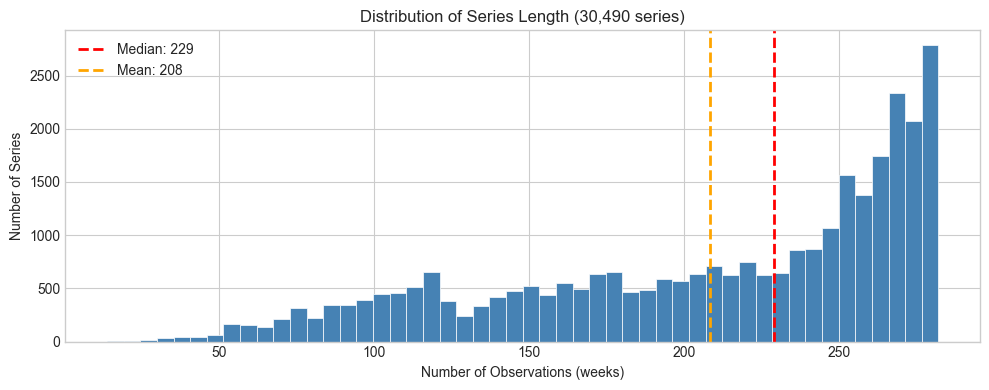

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Series Length (30,490 series)'}, xlabel='Number of Observations (weeks)', ylabel='Number of Series'>)

In [12]:
tfp.plot_series_length_distribution(series_counts, n_series)

### 5.2 Date Range

**Rule of thumb:** Need 2-3x your forecast horizon for meaningful patterns.

For a 12-week forecast, want at least 36 weeks of history.

In [13]:
min_date = df['ds'].min()
max_date = df['ds'].max()
n_weeks = ((max_date - min_date).days // 7) + 1

print(f"Date range: {min_date.date()} to {max_date.date()}")
print(f"Span: {n_weeks} weeks ({n_weeks / 52:.1f} years)")

Date range: 2011-01-29 to 2016-06-18
Span: 282 weeks (5.4 years)


### 5.3 Missing Weeks

Missing weeks create gaps that break lag features and rolling calculations.

**Thresholds:**
- <5% missing: Good — minor imputation if needed
- 5-15% missing: Moderate — investigate cause, plan imputation
- >15% missing: Investigate — may need to exclude or special handling

In [14]:
missing_pcts = df.groupby(id_cols).apply(tfd.pct_missing)

print("Missing weeks (%) across all series:")
print(missing_pcts.describe().round(2))

Missing weeks (%) across all series:
count    30490.00
mean         7.04
std          5.99
min          0.00
25%          2.13
50%          5.67
75%         10.64
max         33.85
dtype: float64


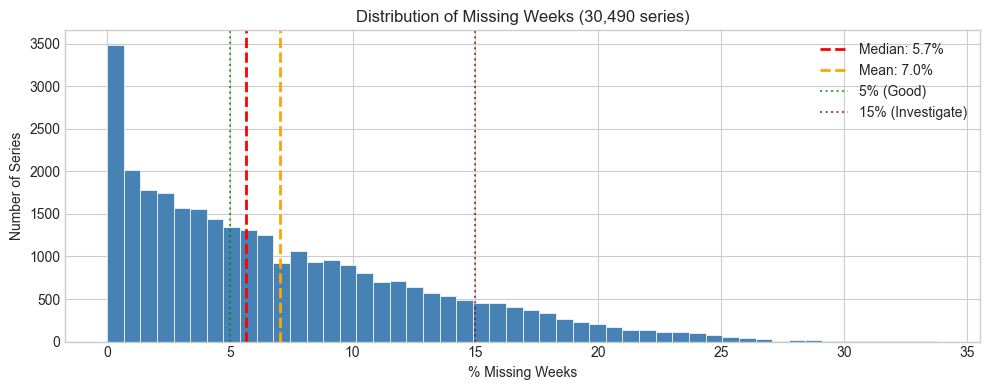

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Missing Weeks (30,490 series)'}, xlabel='% Missing Weeks', ylabel='Number of Series'>)

In [15]:
tfp.plot_missing_weeks_distribution(missing_pcts, n_series=n_series)

### 5.4 Zeros (Intermittency)

High % zeros = intermittent demand. This affects:

- **Metric choice:** MAPE is undefined when actual=0; use RMSE or WRMSSE
- **Model choice:** Standard methods struggle; consider Croston, IMAPA, or tree-based

In [16]:
n_total = len(df)
n_zeros = (df['y'] == 0).sum()
n_na = df['y'].isna().sum()
pct_zeros = n_zeros / n_total * 100

print(f"Total observations: {n_total:,}")
print(f"Zeros:              {n_zeros:,} ({pct_zeros:.1f}%)")
print(f"NAs:                {n_na:,} ({n_na / n_total * 100:.1f}%)")

Total observations: 6,351,266
Zeros:              1,137,327 (17.9%)
NAs:                0 (0.0%)


## 6. Automated First Contact Check using `tsforge`

Run all checks with a single function call `first_contact_check()`. Use this as your standard starting point.

In [17]:
checks = tfd.first_contact_check(df, id_cols=['item_id', 'store_id'])
tfd.print_first_contact_results(checks)

FIRST CONTACT CHECK RESULTS
Series:          30,490
Rows:            6,351,266
Date range:      2011-01-29 to 2016-06-18
Span:            282 weeks
Duplicates:      0
Missing dates:   5.1% median, 32.8% max
Zeros:           17.9%
NAs:             0.0%
Frequency:       ✓ Weekly (7 day gap)


## 7. Save Output for Next Module

Save the cleaned, aggregated weekly data for use in Module 1.7.

**What's included:**
- Weekly aggregated data (item-store-week level)
- Hierarchy columns preserved (dept_id, cat_id, state_id)
- Dtypes fixed, NAs filled, duplicates removed

In [18]:
# Save cleaned weekly data for next module
output_path = DATA_DIR / "1_6_output.parquet"
df.to_parquet(output_path, index=False)

print(f"✓ Saved to {output_path}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  Columns: {list(df.columns)}")

✓ Saved to data/1_6_output.parquet
  Shape: 6,351,266 rows × 7 columns
  Columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y']


## 7. Putting It All Together: 5Q Framework

### What We Learned

| Question | Finding | Status |
|----------|---------|--------|
| **Q1 — Target** | `y` is numeric (unit sales), cleaned from string corruption | ✓ |
| **Q2 — Metric** | ~5% missing weeks median, 18% zeros — MAPE not suitable | ✓ |
| **Q3 — Horizon & Level** | 280+ weeks at item-store-week — sufficient for 12-week horizon | ✓ |
| **Q4 — Data & Drivers** | Moderate intermittency; assess volatility/seasonality next | ☐ |
| **Q5 — Ownership** | TBD — document source, refresh cadence, stakeholders | ☐ |

### Key Decisions

| Decision | Rationale |
|----------|-----------|
| Fill NAs with 0 | Retail: missing = no sales recorded |
| Weekly aggregation | Aligns with business planning cycles |
| Keep all 30K series | Manageable scale; sample for rapid iteration |

### Order of Operations (Reference)
```
Load → Fix dtypes → Fill NAs → Remove duplicates → Aggregate → Run checks
```

## 8. Next Steps

Based on first contact findings:

| Finding | Implication | Addressed In |
|---------|-------------|-------------|
| High missing weeks in some series | Need imputation strategy | Module 1.10 |
| Moderate intermittency (18% zeros) | Affects metric and model choice | Module 2.x |
| ~30K series | May benefit from hierarchical approach | Module 1.7 |

**Coming up:**

- **Module 1.7:** Understanding the M5 Dataset — file structure, field roles (target/dynamic/static)
- **Module 1.8:** Diagnostics — automated profiling of volatility, seasonality, drift
- **Module 1.9:** Portfolio Analysis with GenAI — scale understanding to 30K series
- **Module 1.10:** Data Preparation — fill gaps, merge features, enforce known-at-time discipline